# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_243, but use threshold 0 instead of -1. Show the effect of imbalance.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 16:26:14.834919


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = 'MLP_243' # oops

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 16:26:42.379565
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = 0 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 16:26:43.447095
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 16:26:51.974866
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 16:26:52.280512
Discriminator ZERO 0
Train 1:0 939:2557 26.86%
Valid 1:0 228:647 26.06%
FIT
2023-04-09 16:26:52.342039


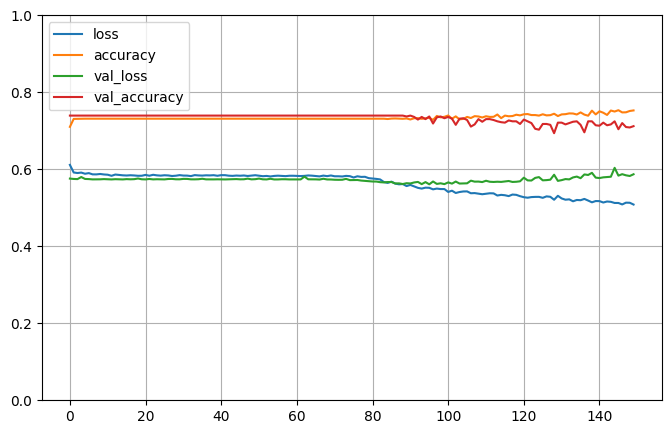

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.1.1.model

Testing # 1 1
2023-04-09 16:28:16.488598
2023-04-09 16:28:16.488655
PREDICT
2023-04-09 16:28:16.497157
Test 1:0 228:647 26.06%
Predict 1:0 74:801  8.46%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.2611334 mean 0.15373026 std
Range of scores: 0.0066732694 to 0.72131914
Score threshold 0.5
Confusion matrix
 [[598  49]
 [203  25]]
Normalized matrix
 [[0.68342857 0.056     ]
 [0.232      0.02857143]]
Extreme scores correct, pos:neg 4 490
Extreme scores incorrect pos:neg 6 152


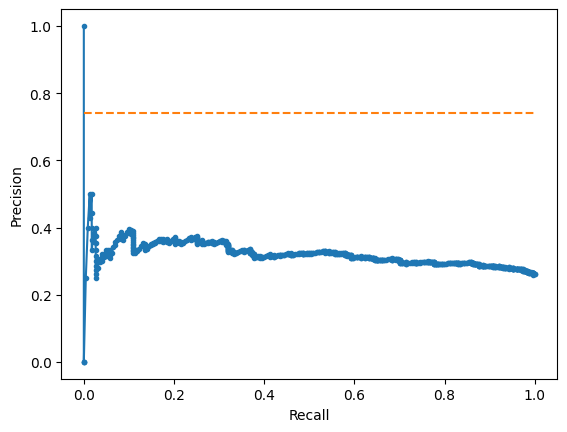

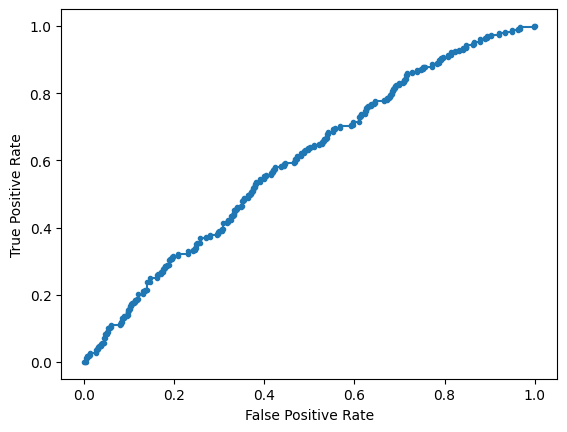

Accuracy: 71.20% Precision: 33.78% Recall: 10.96%
F1: 16.56% MCC: 0.0535
AUPRC: 31.99% AUROC: 59.66%
 accuracy [71.2]
 precision [33.78378378378378]
 recall [10.964912280701753]
 F1 [16.556291390728475]
 MCC [0.053503084615608314]
 AUPRC [31.989344075537318]
 AUROC [59.65861330296375]

Training # 1 2
2023-04-09 16:28:17.210876
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 16:28:17.420705
Discriminator ZERO 0
Train 1:0 926:2570 26.49%
Valid 1:0 241:634 27.54%
FIT
2023-04-09 16:28:17.494056


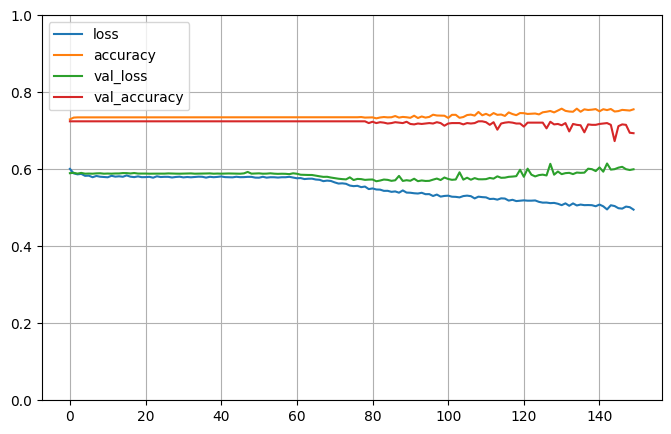

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.1.2.model

Testing # 1 2
2023-04-09 16:29:41.118542
2023-04-09 16:29:41.118829
PREDICT
2023-04-09 16:29:41.122764
Test 1:0 241:634 27.54%
Predict 1:0 125:750 14.29%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.3060442 mean 0.16506612 std
Range of scores: 0.0051353876 to 0.77098775
Score threshold 0.5
Confusion matrix
 [[558  76]
 [192  49]]
Normalized matrix
 [[0.63771429 0.08685714]
 [0.21942857 0.056     ]]
Extreme scores correct, pos:neg 7 419
Extreme scores incorrect pos:neg 8 121


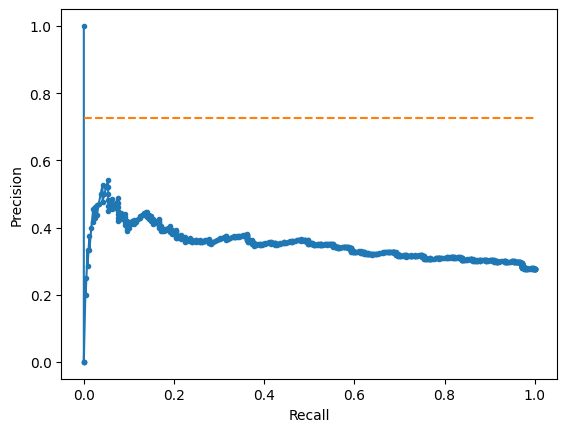

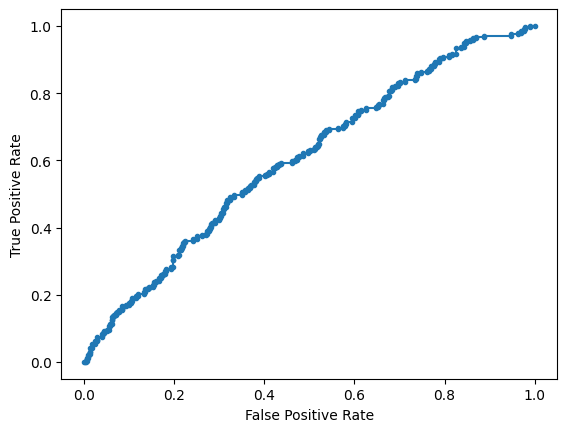

Accuracy: 69.37% Precision: 39.20% Recall: 20.33%
F1: 26.78% MCC: 0.1065
AUPRC: 35.07% AUROC: 60.38%
 accuracy [69.37142857142857]
 precision [39.2]
 recall [20.33195020746888]
 F1 [26.775956284153]
 MCC [0.10652986982737955]
 AUPRC [35.072757810484276]
 AUROC [60.37671636320798]

Training # 1 3
2023-04-09 16:29:41.589170
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 16:29:41.814467
Discriminator ZERO 0
Train 1:0 951:2546 27.19%
Valid 1:0 216:658 24.71%
FIT
2023-04-09 16:29:41.876383


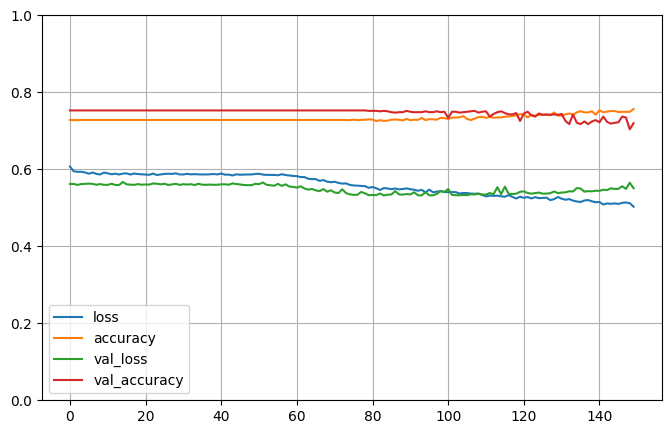

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.1.3.model

Testing # 1 3
2023-04-09 16:30:40.403929
2023-04-09 16:30:40.403979
PREDICT
2023-04-09 16:30:40.408903
Test 1:0 216:658 24.71%
Predict 1:0 83:791  9.50%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.26735702 mean 0.15684405 std
Range of scores: 0.0033149202 to 0.7298248
Score threshold 0.5
Confusion matrix
 [[602  56]
 [189  27]]
Normalized matrix
 [[0.68878719 0.06407323]
 [0.21624714 0.03089245]]
Extreme scores correct, pos:neg 2 493
Extreme scores incorrect pos:neg 10 130


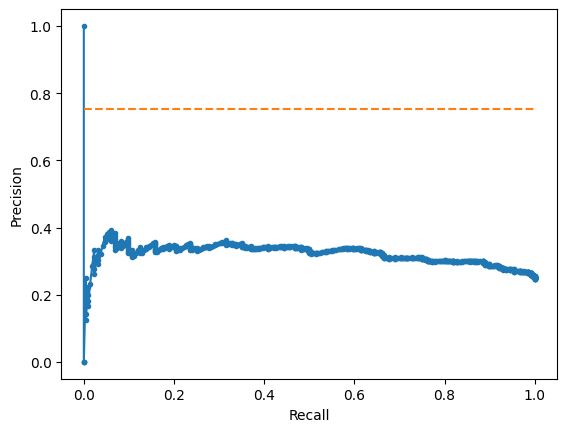

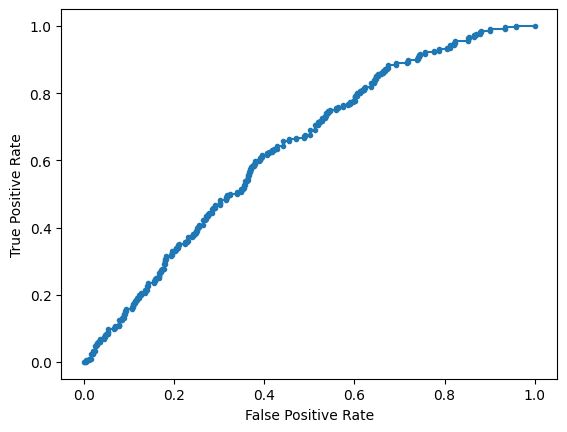

Accuracy: 71.97% Precision: 32.53% Recall: 12.50%
F1: 18.06% MCC: 0.0587
AUPRC: 32.13% AUROC: 63.51%
 accuracy [71.96796338672769]
 precision [32.53012048192771]
 recall [12.5]
 F1 [18.06020066889632]
 MCC [0.05869700588228635]
 AUPRC [32.13054142814266]
 AUROC [63.50824608803332]

Training # 1 4
2023-04-09 16:30:40.857130
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 16:30:41.071527
Discriminator ZERO 0
Train 1:0 936:2561 26.77%
Valid 1:0 231:643 26.43%
FIT
2023-04-09 16:30:41.132433


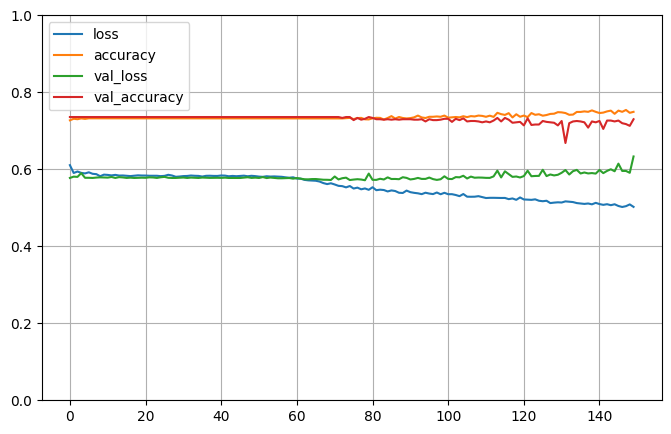

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.1.4.model

Testing # 1 4
2023-04-09 16:31:39.525897
2023-04-09 16:31:39.525970
PREDICT
2023-04-09 16:31:39.531868
Test 1:0 231:643 26.43%
Predict 1:0 31:843  3.55%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.18280783 mean 0.14045247 std
Range of scores: 0.0023562633 to 0.71036196
Score threshold 0.5
Confusion matrix
 [[625  18]
 [218  13]]
Normalized matrix
 [[0.71510297 0.02059497]
 [0.24942792 0.01487414]]
Extreme scores correct, pos:neg 2 563
Extreme scores incorrect pos:neg 1 186


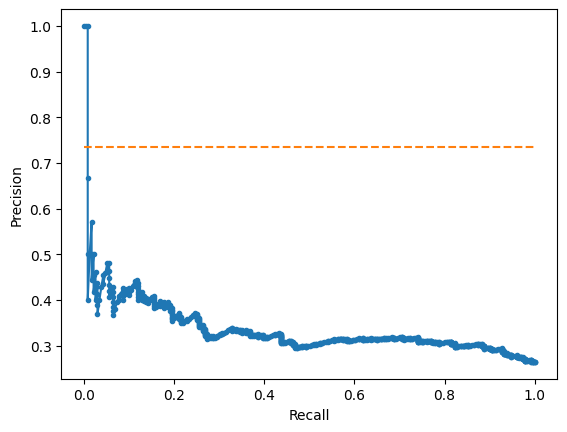

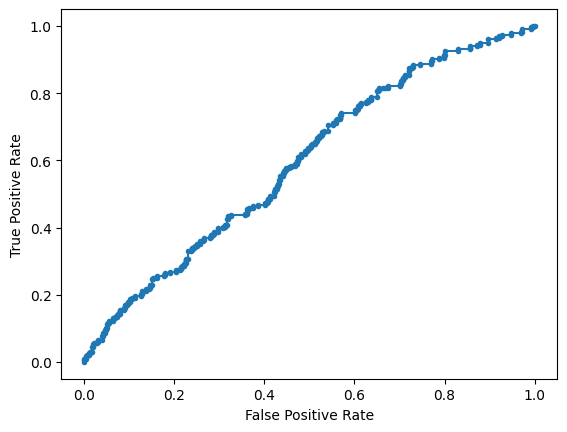

Accuracy: 73.00% Precision: 41.94% Recall: 5.63%
F1: 9.92% MCC: 0.0674
AUPRC: 33.75% AUROC: 59.54%
 accuracy [72.99771167048054]
 precision [41.935483870967744]
 recall [5.627705627705628]
 F1 [9.923664122137405]
 MCC [0.06742897701251821]
 AUPRC [33.74700115371648]
 AUROC [59.542323928015996]

Training # 1 5
2023-04-09 16:31:40.057189
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 16:31:40.346942
Discriminator ZERO 0
Train 1:0 916:2582 26.19%
Valid 1:0 251:622 28.75%
FIT
2023-04-09 16:31:40.411552


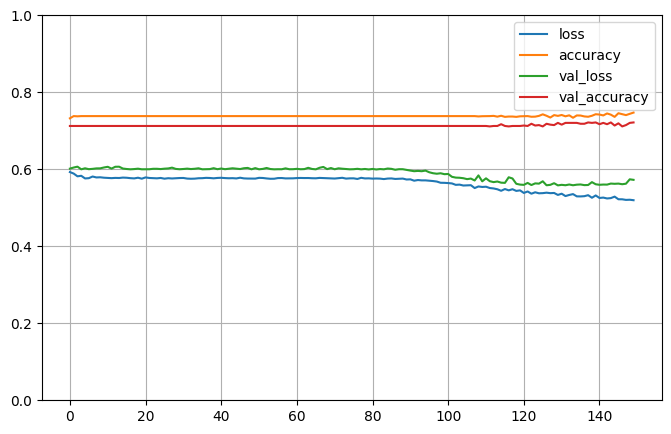

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.1.5.model

Testing # 1 5
2023-04-09 16:33:04.274755
2023-04-09 16:33:04.274972
PREDICT
2023-04-09 16:33:04.279803
Test 1:0 251:622 28.75%
Predict 1:0 22:851  2.52%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.23409419 mean 0.13247019 std
Range of scores: 0.011130203 to 0.61101925
Score threshold 0.5
Confusion matrix
 [[615   7]
 [236  15]]
Normalized matrix
 [[0.70446735 0.00801833]
 [0.27033219 0.01718213]]
Extreme scores correct, pos:neg 0 522
Extreme scores incorrect pos:neg 0 159


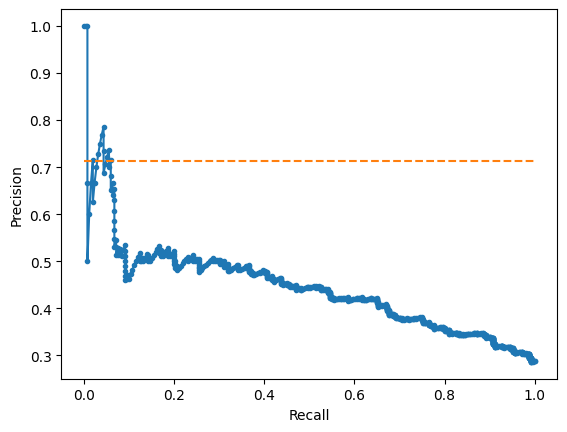

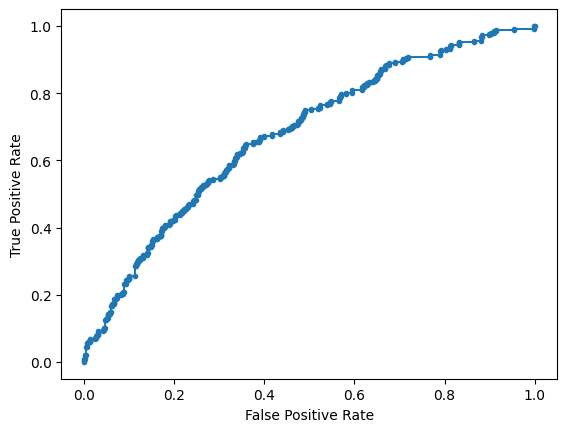

Accuracy: 72.16% Precision: 68.18% Recall: 5.98%
F1: 10.99% MCC: 0.1401
AUPRC: 44.65% AUROC: 67.64%
 accuracy [72.16494845360825]
 precision [68.18181818181817]
 recall [5.9760956175298805]
 F1 [10.989010989010989]
 MCC [0.14007472653790756]
 AUPRC [44.65457240840285]
 AUROC [67.6394102048398]

Training # 2 1
2023-04-09 16:33:04.751906
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 16:33:04.950250
Discriminator ZERO 0
Train 1:0 941:2555 26.92%
Valid 1:0 226:649 25.83%
FIT
2023-04-09 16:33:05.020280


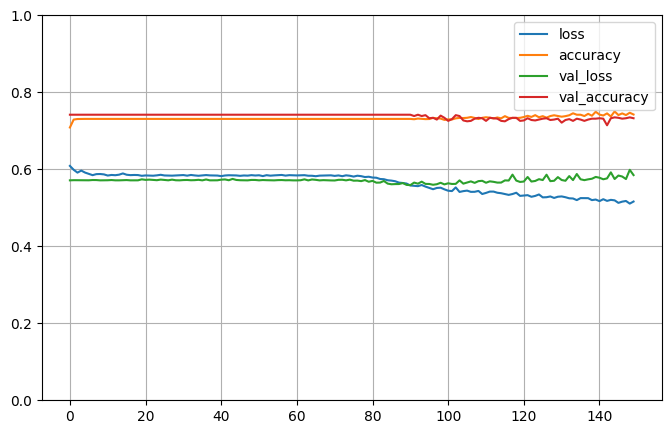

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.2.1.model

Testing # 2 1
2023-04-09 16:34:03.227606
2023-04-09 16:34:03.227819
PREDICT
2023-04-09 16:34:03.232444
Test 1:0 226:649 25.83%
Predict 1:0 40:835  4.57%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.22948307 mean 0.13776244 std
Range of scores: 0.00474777 to 0.6832111
Score threshold 0.5
Confusion matrix
 [[625  24]
 [210  16]]
Normalized matrix
 [[0.71428571 0.02742857]
 [0.24       0.01828571]]
Extreme scores correct, pos:neg 0 537
Extreme scores incorrect pos:neg 3 172


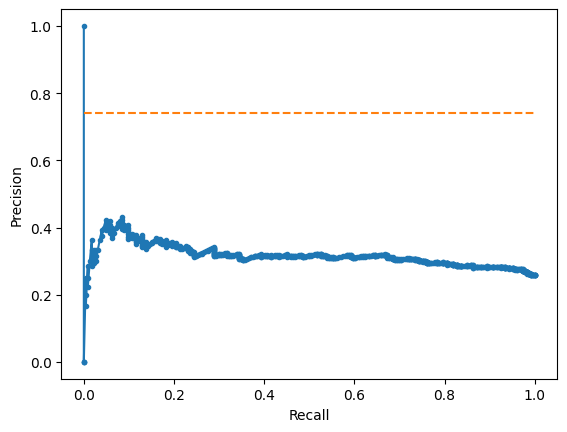

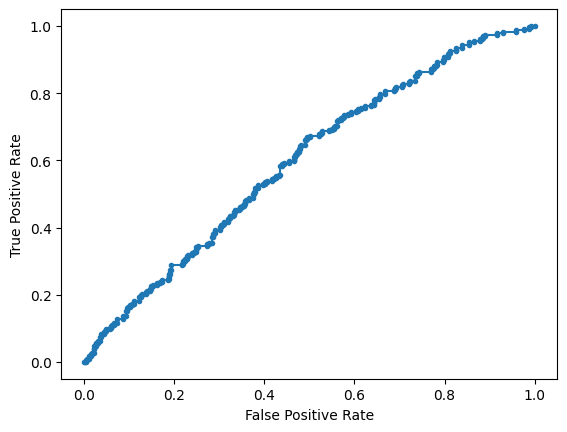

Accuracy: 73.26% Precision: 40.00% Recall: 7.08%
F1: 12.03% MCC: 0.0709
AUPRC: 31.65% AUROC: 59.61%
 accuracy [73.25714285714285]
 precision [40.0]
 recall [7.079646017699115]
 F1 [12.030075187969924]
 MCC [0.07086501364942645]
 AUPRC [31.6511786470493]
 AUROC [59.61247392175846]

Training # 2 2
2023-04-09 16:34:03.677168
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 16:34:03.885292
Discriminator ZERO 0
Train 1:0 929:2567 26.57%
Valid 1:0 238:637 27.20%
FIT
2023-04-09 16:34:03.948458


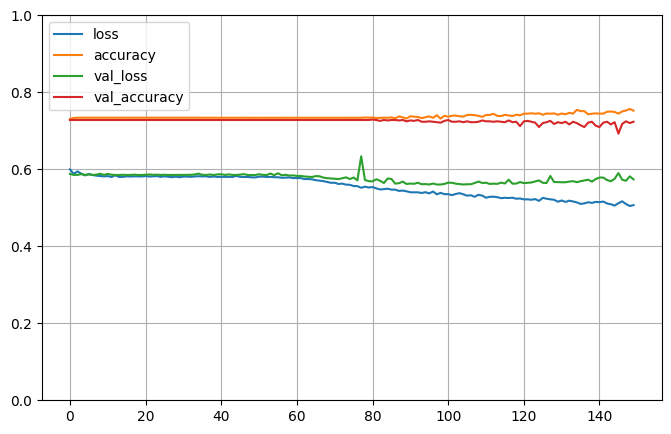

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.2.2.model

Testing # 2 2
2023-04-09 16:35:01.005458
2023-04-09 16:35:01.005513
PREDICT
2023-04-09 16:35:01.011019
Test 1:0 238:637 27.20%
Predict 1:0 86:789  9.83%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.26792547 mean 0.15714517 std
Range of scores: 0.0072074337 to 0.7130216
Score threshold 0.5
Confusion matrix
 [[592  45]
 [197  41]]
Normalized matrix
 [[0.67657143 0.05142857]
 [0.22514286 0.04685714]]
Extreme scores correct, pos:neg 2 481
Extreme scores incorrect pos:neg 4 136


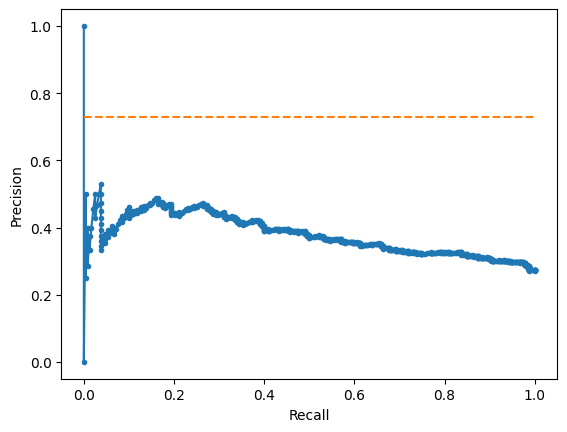

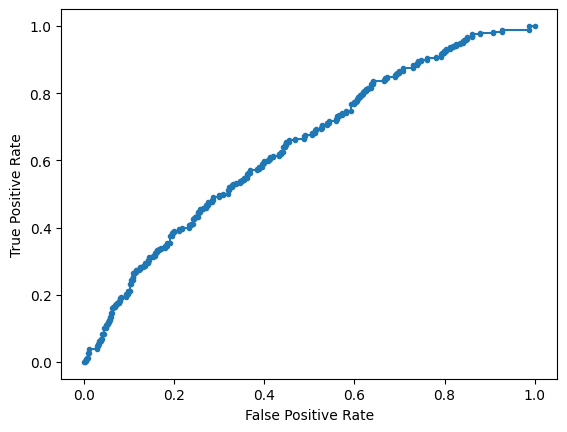

Accuracy: 72.34% Precision: 47.67% Recall: 17.23%
F1: 25.31% MCC: 0.1519
AUPRC: 37.75% AUROC: 64.18%
 accuracy [72.34285714285714]
 precision [47.674418604651166]
 recall [17.22689075630252]
 F1 [25.308641975308642]
 MCC [0.15190503204285077]
 AUPRC [37.754546680155954]
 AUROC [64.17951796103057]

Training # 2 3
2023-04-09 16:35:01.558865
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 16:35:01.790294
Discriminator ZERO 0
Train 1:0 924:2573 26.42%
Valid 1:0 243:631 27.80%
FIT
2023-04-09 16:35:02.407385


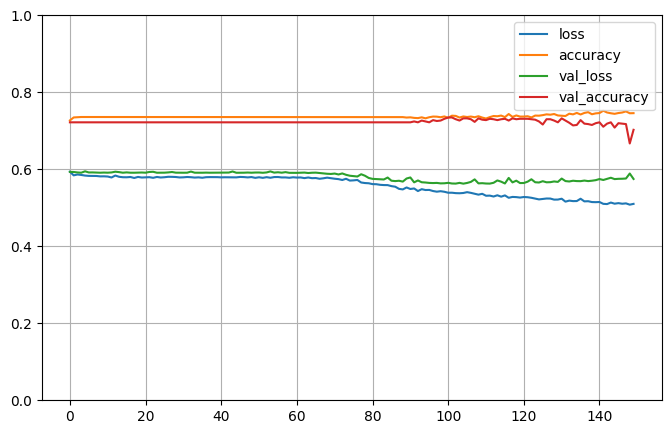

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.2.3.model

Testing # 2 3
2023-04-09 16:36:01.292914
2023-04-09 16:36:01.293121
PREDICT
2023-04-09 16:36:01.297859
Test 1:0 243:631 27.80%
Predict 1:0 89:785 10.18%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.30246973 mean 0.14453746 std
Range of scores: 0.015988136 to 0.6675841
Score threshold 0.5
Confusion matrix
 [[578  53]
 [207  36]]
Normalized matrix
 [[0.66132723 0.06064073]
 [0.23684211 0.04118993]]
Extreme scores correct, pos:neg 1 409
Extreme scores incorrect pos:neg 0 122


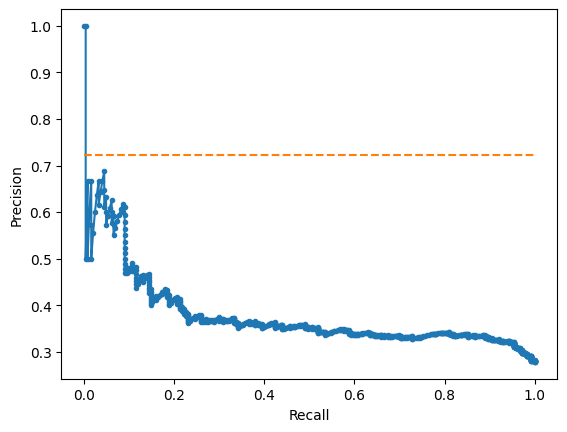

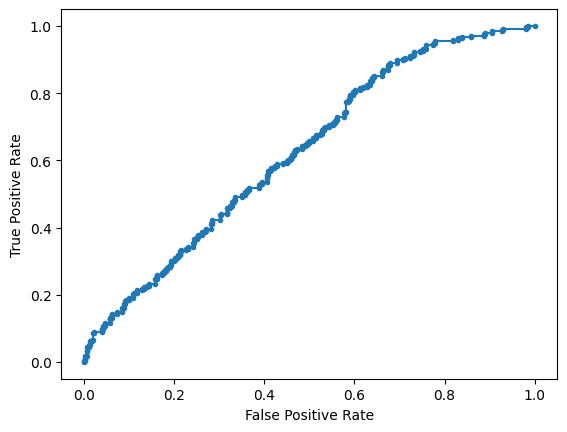

Accuracy: 70.25% Precision: 40.45% Recall: 14.81%
F1: 21.69% MCC: 0.0950
AUPRC: 38.01% AUROC: 62.59%
 accuracy [70.25171624713958]
 precision [40.44943820224719]
 recall [14.814814814814813]
 F1 [21.686746987951803]
 MCC [0.09504188106763095]
 AUPRC [38.00523339603817]
 AUROC [62.59122302439789]

Training # 2 4
2023-04-09 16:36:01.767404
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 16:36:01.954692
Discriminator ZERO 0
Train 1:0 953:2545 27.24%
Valid 1:0 214:659 24.51%
FIT
2023-04-09 16:36:02.017241


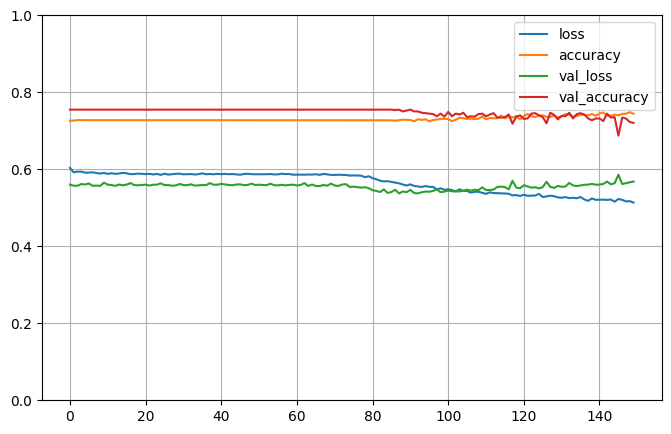

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.2.4.model

Testing # 2 4
2023-04-09 16:37:25.762126
2023-04-09 16:37:25.762598
PREDICT
2023-04-09 16:37:25.769379
Test 1:0 214:659 24.51%
Predict 1:0 100:773 11.45%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.28832814 mean 0.15713772 std
Range of scores: 0.0055124387 to 0.7351344
Score threshold 0.5
Confusion matrix
 [[594  65]
 [179  35]]
Normalized matrix
 [[0.68041237 0.0744559 ]
 [0.20504009 0.04009164]]
Extreme scores correct, pos:neg 2 465
Extreme scores incorrect pos:neg 10 123


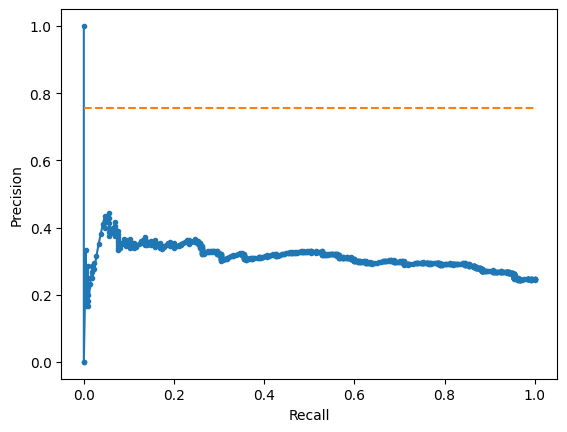

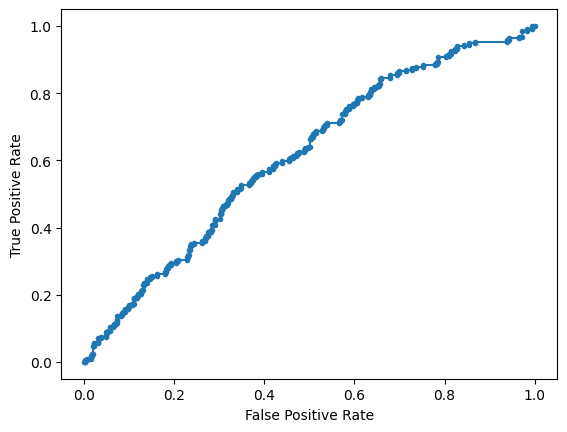

Accuracy: 72.05% Precision: 35.00% Recall: 16.36%
F1: 22.29% MCC: 0.0877
AUPRC: 31.19% AUROC: 61.13%
 accuracy [72.0504009163803]
 precision [35.0]
 recall [16.355140186915886]
 F1 [22.29299363057325]
 MCC [0.08768372830661304]
 AUPRC [31.1896259840042]
 AUROC [61.12702622211508]

Training # 2 5
2023-04-09 16:37:26.273211
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 16:37:26.475807
Discriminator ZERO 0
Train 1:0 921:2576 26.34%
Valid 1:0 246:628 28.15%
FIT
2023-04-09 16:37:26.547350


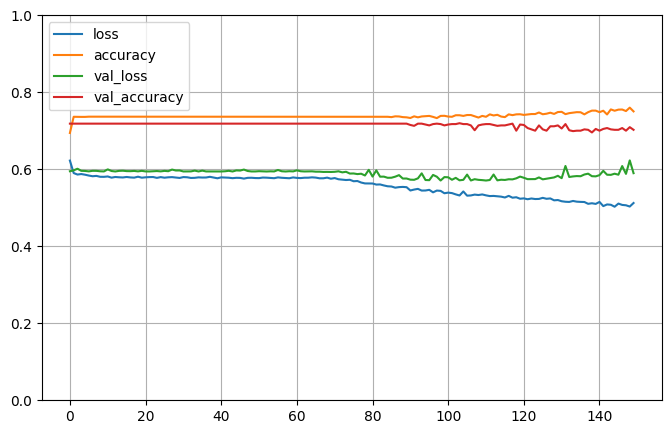

Saved model to /content/drive/My Drive/data/Localization/Models/MLP_243.2.5.model

Testing # 2 5
2023-04-09 16:38:50.313759
2023-04-09 16:38:50.313826
PREDICT
2023-04-09 16:38:50.319171
Test 1:0 246:628 28.15%
Predict 1:0 88:786 10.07%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.27584314 mean 0.15042625 std
Range of scores: 0.0053974004 to 0.70790285
Score threshold 0.5
Confusion matrix
 [[577  51]
 [209  37]]
Normalized matrix
 [[0.66018307 0.0583524 ]
 [0.23913043 0.0423341 ]]
Extreme scores correct, pos:neg 0 467
Extreme scores incorrect pos:neg 4 141


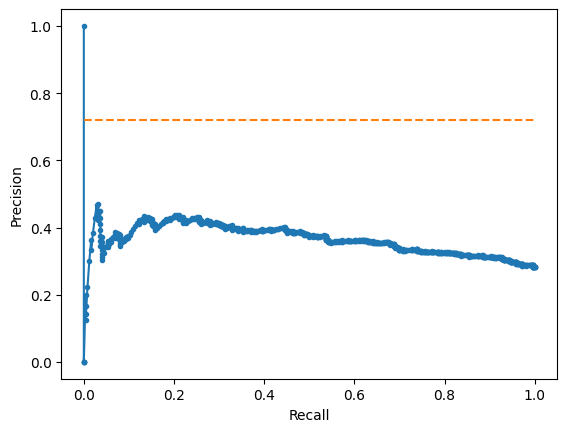

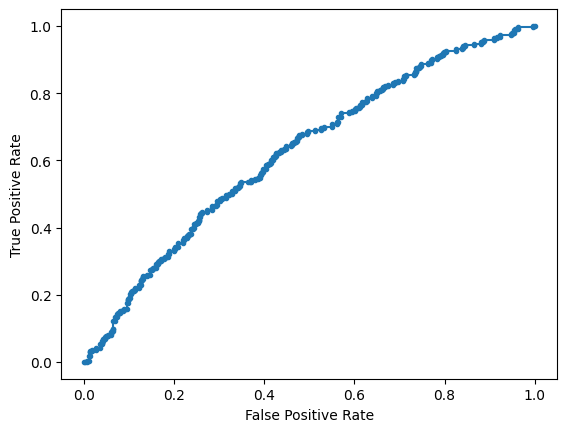

Accuracy: 70.25% Precision: 42.05% Recall: 15.04%
F1: 22.16% MCC: 0.1034
AUPRC: 36.35% AUROC: 62.34%
 accuracy [70.25171624713958]
 precision [42.04545454545455]
 recall [15.040650406504067]
 F1 [22.15568862275449]
 MCC [0.10341361518893001]
 AUPRC [36.35442406323596]
 AUROC [62.34464812800995]
2023-04-09 16:38:50.799024


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 71.59% std 1.28
 precision mean 42.08% std 10.21
 recall mean 12.59% std 5.07
 F1 mean 18.58% std 6.04
 MCC mean 0.0935 std 0.0331
 AUPRC mean 35.25% std 4.16
 AUROC mean 62.06% std 2.58
 accuracy [[71.2], [69.37142857142857], [71.96796338672769], [72.99771167048054], [72.16494845360825], [73.25714285714285], [72.34285714285714], [70.25171624713958], [72.0504009163803], [70.25171624713958]]
 precision [[33.78378378378378], [39.2], [32.53012048192771], [41.935483870967744], [68.18181818181817], [40.0], [47.674418604651166], [40.44943820224719], [35.0], [42.04545454545455]]
 recall [[10.964912280701753], [20.33195020746888], [12.5], [5.627705627705628], [5.9760956175298805], [7.079646017699115], [17.22689075630252], [14.814814814814813], [16.355140186915886], [15.040650406504067]]
 F1 [[16.556291390728475], [26.775956284153], [18.06020066889632], [9.923664122137405], [10.989010989010989], [12.030075187969924], [25.308641975308642], [21.686746987951803], [22.29299363057325]